<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc
from jax_ib.base import grids, fast_diagonalization, boundaries, pressure, diffusion, advection, finite_differences, IBM_Force,convolution_functions,particle_motion, equations
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct
import scipy 
import tree_math
from jax_ib.base import array_utils

In [3]:
from functools import partial

import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map

In [4]:
jax.devices()

[CudaDevice(id=0),
 CudaDevice(id=1),
 CudaDevice(id=2),
 CudaDevice(id=3),
 CudaDevice(id=4),
 CudaDevice(id=5),
 CudaDevice(id=6),
 CudaDevice(id=7)]

In [51]:
#-- Initial velocity profile
def fun(x):
    return np.cos(x)

TypeError: fun() takes 1 positional argument but 2 were given

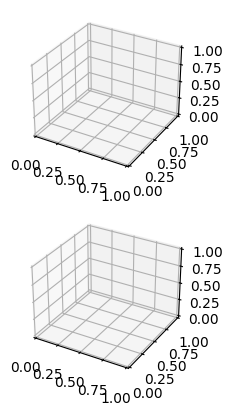

In [52]:
offsets = [(0,0), (0.5, 0.5)]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},ncols=1, nrows=len(offsets))
for n, o in enumerate(offsets):
    ev = grid.eval_on_mesh(fun, offset=o)
    mesh = grid.mesh(offset=o)
    ax[n].plot_surface(np.array(mesh[0]), np.array(mesh[1]), ev.data)

In [7]:
a = grid.eval_on_mesh(fun, offsets[0])
b = grid.eval_on_mesh(fun, offsets[1])
a + b # breaks due to inconsistent offsets

InconsistentOffsetError: arrays do not have a unique offset: {(0.5, 0.5), (0, 0)}

<font size="5"> Velocity fields live on the boundary surfaces between cells (offsets for vx and vy are  (1,0.5) and (0.5, 1)). Pressure lives at the cell center at offset = (0.5,0.5)<font size="5">v

In [10]:
#-- Flow conditions
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=5e-4          # time step 

#-- CFD Boundary condition parameters
# parameters to parametrize time-dependent boundary conditions on walls of fluid domain
# ultimately we'd like to take e.g. a derivative over conditions
num_boundaries = 4 # in two dimensions there are 4 boundaries

domain = ((0,15.),(0,15.0))
size=(600,600)
grid = grids.Grid(size, domain=domain) #gridpoints in 

#def Boundary_fn(t): #can onlu depend on time at this point
#    return 0.0
# define boundary-condition functions which determine the fluid velocity at the boundaries
# of the domain; this is in 2D, so there are 4 boundaries. Boundaries can in principle
# be time dependent. There is one function per bounding surface and per velocity component, i.e.
# v_x_surface_1(t), v_y_surface_1(t), v_x_surface_2(t), ..., v_y_surface_4(t)
bc_fns = [lambda t: 0.0 for _ in range(num_boundaries)] #define boundary functions
vx_bc=((bc_fns[0](0.0), bc_fns[1](0.0)), (bc_fns[2](0.0),bc_fns[3](0.0)))
vy_bc=((0.0, 0.0), (0, 0.0))

# the values for bc_vals are actually violating the documented required values for periodic 
# boundary conditions; is this a problem????
# the docstring of the function boundaries.new_periodic_boundary_conditions seems to be outdated
# check with Mohammed if the description is still correct
velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)


#velocity_fns = (vx_fn, vy_fn)
# compute the initial values of the PDE variables (vx, vy in this case) over the grid
vx_0, vy_0 = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)
v0 = (vx_0, vy_0)
# Mohammed said they're using staggered mesh, pressure in the center, velolicites at the upper and left edge of the cell-square
# is this correct though? jax-cfd seems to be using arakawa c-grid with velocities at the face centers, and pressures on the edges?
#-- Initial Pressure Profile
# vx_0.bc.boundary_fn needs to be used here otherwise a 
# jax.lax.scan call will fail (need to investigate why this happens)
pressure0 = grids.GridVariable(
    grids.GridArray(jnp.zeros(grid.shape), grid.cell_center, grid), 
    boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)))

<font size="5"> Immersed Boudary Kinematics <font size="5">

In [9]:
#-- Immersed objects

# Immersed Objects Geometery and Initial locations
# object is described by center of the object
# theta is here a dummy variable; if f-term was used in addition to the f_b term, we'd need theat
def ellipse(geometry_param,theta):
    A = geometry_param[0]
    B = geometry_param[1]
    ntheta=150#30#400#51
    #xt = jnp.array(theta[:len(theta)//2]/(jnp.pi))
    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)


particle_geometry_param = jnp.array([[0.5,0.06]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects


# Immersed Objects kinematics
displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([[jnp.pi/2,jnp.pi/4,0.25,0]])
#rotation_param = jnp.array([jnp.pi])

Displacement_EQ = ks.displacement # harmonic movement of the center in x-direction, coonstant in y-direction
Rotation_EQ = ks.rotation2 # constant rotation of the ellipse


mygrids = pc.Grid1d(2, domain= (0, 2*jnp.pi)) # Only needed when using Penalty method simulation setup

#wrap everythin into a single convenience object
particles =  pc.Particle(particle_center_position,
                         particle_geometry_param,
                         displacement_param,
                         rotation_param,mygrids,
                         ellipse,
                         Displacement_EQ,
                         Rotation_EQ)

In [22]:
def laplacian_matrix(size: int, step: float) -> np.ndarray:
    """Create 1D Laplacian operator matrix, with periodic BC."""
    column = np.zeros(size)
    column[0] = -2 / step**2
    column[1] = column[-1] = 1 / step**2
    return scipy.linalg.circulant(column)

In [10]:
inner_steps = 50#1800#20#450#1500#1300
outer_steps = 40#6000#12000#3000#2000#4500#4500#1800#10#900#20 (18000 works well to reach steady state)

#-- Setup Pytree Variable to be looped over during integration steps

Intermediate_calcs = [0] ## If one is interested to perform post-calculation without the need to save large trajectories
Step_counter = 0
MD_state = [0] # Needed when combinting Brownian integration with the Immersed Boundary simulation

all_variables = pc.All_Variables(particles,v0,pressure0,Intermediate_calcs,Step_counter,MD_state)


In [24]:
laplacian_matrix(100,1)

array([[-2.,  1.,  0., ...,  0.,  0.,  1.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1., -2.]])

<font size="5"> Simulation Setup <font size="5">

In [11]:

#-- IB force coupling functions
def internal_post_processing(all_variables,dt):
    return all_variables

# Force convolution kernel
discrete_delta = lambda x,x0,w1: convolution_functions.gaussian(x,x0,w1)

# Convolution Discretized Integral
surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,discrete_delta)

IBM_forcing = lambda variables,dt: IBM_Force.immersed_boundary_force(variables[0], #velocity,
                                                                     variables[1], #particles 
                                                                     discrete_delta,
                                                                     surf_fn,
                                                                     dt)
# Update particle position function
Update_position = particle_motion.Update_particle_position_Multiple

def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)

single_step = ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag, #only works for periodic boundary conditions
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated, #use runge-kutta , and keep it like that
        IBM_forcing = IBM_forcing, #comput ethe forcing term to update the particle
        Updating_Position = Update_position,
        Drag_fn = internal_post_processing, ### TO be removed from the example
        )
step_fn = cfd.funcutils.repeated(single_step, steps=inner_steps)

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))

In [72]:
mesh2d = jax.make_mesh((4, 2), ('i', 'j'))

In [73]:
#grid = jax_ib.base.grids.Grid(shape=(16,16) ,domain = ((0,16),(0,16)), device_mesh=mesh2d)


In [90]:
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=5e-4          # time step 
num_boundaries = 4
grid = grids.Grid((128,128), domain=((0,15.),(0,15.0)), device_mesh = mesh2d, periods = (15,15)) #gridpoints in 
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)
vx_0, vy_0 = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)
v0 = (vx_0, vy_0)
global_pressure = grids.GridVariable(
    grids.GridArray(jnp.zeros(grid.shape), grid.cell_center, grid), 
    boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)))




subgrid=grid.subgrid((1,1),boundary_layer_widths=(1,1))

In [122]:
def gather_boundary_layers(array):
    I, J = jax.lax.psum(1, 'i'), jax.lax.psum(1, 'j')
    left_halo = jax.lax.ppermute(array[:,-1], 'j', [(j, (j + 1) % J) for j in range(J)])
    right_halo = jax.lax.ppermute(array[:,0], 'j', [(j, (j - 1) % J) for j in range(J)])
    upper_halo = jax.lax.ppermute(array[-1,:], 'i', [(i, (i + 1) % I) for i in range(I)])
    lower_halo = jax.lax.ppermute(array[0,:], 'i', [(i, (i - 1) % I) for i in range(I)])
    
    upper_halo = jnp.append(0.0, jnp.append(upper_halo, 0.0))
    lower_halo = jnp.append(0.0, jnp.append(lower_halo, 0.0))
    
    temp = jnp.concatenate([left_halo[:,None], array, right_halo[:,None]], axis=1)
    return  jnp.concatenate([upper_halo[None, :], temp, lower_halo[None,:]], axis=0)

def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)


# we assume all subgrids have identical shapes and steps
def get_subgrid_laplacians(grid, boundary_layer_widths):
    subgrid = grid.subgrid((1,1), boundary_layer_widths)
    return tuple([jnp.array(a) for a in list(map(array_utils.laplacian_matrix,subgrid.shape, subgrid.step))])

####################################################################
# this requires more investigation to be sure it actually runs distributed and isnt' causing any
# unwanted host-device comms
boundary_layer_widths = (1,1)
laplacians = get_subgrid_laplacians(grid, boundary_layer_widths)
pinv = fast_diagonalization.pseudoinverse(
    laplacians,global_pressure.array.data.dtype, 
    hermitian=True,circulant=True,implementation=None)
pinv(np.ones(laplacians[1].shape[0]).astype(np.float32))
####################################################################


@partial(shard_map, mesh=mesh2d, in_specs=(P('i','j'),(P('i','j'), P('i','j')), None,None,(None,None)), out_specs=((P('i','j'),P('i','j')), P('i','j')))
def master(global_pressure, global_velocities, grid, boundary_layer_widths, laplacians):
    local_pressure = gather_boundary_layers(global_pressure)
    global_ux, global_uy = global_velocities

    
    local_ux = gather_boundary_layers(global_ux)
    local_uy = gather_boundary_layers(global_uy)
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)#, boundary_conditions = ('periodic','periodic'))
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    pressure_bc = ((0.0, 0.0), (0.0, 0.0))
    boundary_condition = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=pressure_bc,bc_fn=bc_fns,time_stamp=0.0)

    velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                   boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))

    local_pressure = grids.GridVariable(grids.GridArray(local_pressure, subgrid.cell_center, subgrid), boundary_condition)
    local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bc[0])
    local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bc[1])
    
    explicit_update = equations.navier_stokes_explicit_terms(
        density=1.0, viscosity=1.0, dt=5E-4,grid=subgrid, convect=convect, diffuse=diffusion.diffuse, forcing=None)
    explicit = explicit_update((local_ux, local_uy))
    dP = finite_differences.forward_difference(local_pressure)

    local_u_star = tuple([u.array.data + dt * e.array.data - dp.data for u, e, dp in zip((local_ux, local_uy), explicit, dP)])
    local_u_star = tuple([grids.GridVariable(grids.GridArray(u, os, subgrid), bc) for os, u, bc in zip(subgrid.cell_faces, local_u_star, velocity_bc)])
   
    local_u_final, new_local_pressure= pressure.projection_and_update_pressure(local_pressure, local_u_star, pinv)
    return tuple([u.array.data for u in local_u_final]), new_local_pressure.array.data

In [123]:
subgrid_laplacians = get_subgrid_laplacians(grid, boundary_layer_widths)
y = master(global_pressure.array.data, (vx_0.array.data, vy_0.array.data), grid,boundary_layer_widths, subgrid_laplacians)
print('FINAL RESULT:\n', y)

FINAL RESULT:
 ((Array([[0.5355639 , 0.8930345 , 0.9865329 , ..., 1.1325518 , 1.2622547 ,
        0.802761  ],
       [0.7995359 , 0.8930347 , 0.9540392 , ..., 1.0727541 , 1.0738642 ,
        0.90533894],
       [0.9048818 , 0.9255292 , 0.9540402 , ..., 1.0323198 , 1.0123001 ,
        0.947328  ],
       ...,
       [0.905082  , 1.0711942 , 1.0723054 , ..., 0.95433354, 0.8939764 ,
        0.801521  ],
       [0.8004292 , 1.2595847 , 1.1338688 , ..., 0.98643106, 0.8939762 ,
        0.53789556],
       [0.5355639 , 1.1570066 , 1.0918789 , ..., 1.0904495 , 1.1576016 ,
        0.53789556]], dtype=float32), Array([[0.5374064 , 0.8013785 , 0.9067246 , ..., 0.90692484, 0.80227196,
        0.5374064 ],
       [0.8948771 , 0.8948769 , 0.92737055, ..., 1.0730366 , 1.261427  ,
        1.1588492 ],
       [0.98837584, 0.9558815 , 0.9558804 , ..., 1.0741467 , 1.1357107 ,
        1.0937217 ],
       ...,
       [1.1343938 , 1.0745953 , 1.034161  , ..., 0.95617574, 0.98827404,
        1.0922922 ],
  

In [67]:
laplacians = tuple([jnp.array(a) for a in list(map(array_utils.laplacian_matrix,grid.shape, grid.step))])
pressure_correction = pressure.projection_and_update_pressure(global_pressure, v0, laplacians)

rfft


Array([[-0.03887625, -0.03887625, -0.03887625, ..., -0.03887625,
        -0.03887625, -0.03887625],
       [-0.03221175, -0.03221175, -0.03221175, ..., -0.03221175,
        -0.03221175, -0.03221175],
       [-0.02595116, -0.02595116, -0.02595116, ..., -0.02595116,
        -0.02595116, -0.02595116],
       ...,
       [-0.02009448, -0.02009448, -0.02009448, ..., -0.02009448,
        -0.02009448, -0.02009448],
       [-0.02595116, -0.02595116, -0.02595116, ..., -0.02595116,
        -0.02595116, -0.02595116],
       [-0.03221175, -0.03221175, -0.03221175, ..., -0.03221175,
        -0.03221175, -0.03221175]], dtype=float32)

In [105]:
[l.shape for l in laplacians]

[(34, 34), (66, 66)]

In [98]:
grid.subgrid((1,1), boundary_layer_widths=(1,1))

Grid(shape=(34, 66), step=(Array(0.1171875, dtype=float32), Array(0.1171875, dtype=float32)), domain=((Array(3.6328125, dtype=float32), Array(7.6171875, dtype=float32)), (Array(7.3828125, dtype=float32), Array(15.1171875, dtype=float32))), periods=(15, 15), device_mesh=None)

In [100]:
[l.shape for l in laplacians]

[(34, 34), (66, 66)]

In [110]:
laplacians = get_subgrid_laplacians(grid, (1,1))
pinv = fast_diagonalization.pseudoinverse(
    laplacians,global_pressure.array.data.dtype, 
    hermitian=True,circulant=True,implementation=None)
pinv(np.ones(laplacians[1].shape[0]).astype(np.float32))

Array([[-0.03887625, -0.03887625, -0.03887625, ..., -0.03887625,
        -0.03887625, -0.03887625],
       [-0.03221175, -0.03221175, -0.03221175, ..., -0.03221175,
        -0.03221175, -0.03221175],
       [-0.02595116, -0.02595116, -0.02595116, ..., -0.02595116,
        -0.02595116, -0.02595116],
       ...,
       [-0.02009448, -0.02009448, -0.02009448, ..., -0.02009448,
        -0.02009448, -0.02009448],
       [-0.02595116, -0.02595116, -0.02595116, ..., -0.02595116,
        -0.02595116, -0.02595116],
       [-0.03221175, -0.03221175, -0.03221175, ..., -0.03221175,
        -0.03221175, -0.03221175]], dtype=float32)

TypeError: mul got incompatible shapes for broadcasting: (34, 34), (66, 34).

In [78]:
pressure_correction = pressure.projection_and_update_pressure(global_pressure, v0, pinv)

In [79]:
pressure_correction

((
  GridVariable
       GridArray
          Array([[1., 1., 1., ..., 1., 1., 1.],
                 [1., 1., 1., ..., 1., 1., 1.],
                 [1., 1., 1., ..., 1., 1., 1.],
                 ...,
                 [1., 1., 1., ..., 1., 1., 1.],
                 [1., 1., 1., ..., 1., 1., 1.],
                 [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
          Grid(shape=(4096, 4096), step=(Array(0.00366211, dtype=float32), Array(0.00366211, dtype=float32)), domain=((Array(0., dtype=float32), Array(15., dtype=float32)), (Array(0., dtype=float32), Array(15., dtype=float32))), periods=(15, 15), device_mesh=Mesh(device_ids=array([[0, 1],
                 [2, 3],
                 [4, 5],
                 [6, 7]]), axis_names=('i', 'j')))
          offset: (1.0, 0.5)
      Boundary Condition: ConstantBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0)), boundary_fn=[<function <lambda> at 0x7f5cb8187600>, <function <lambda>

In [13]:
grid.

(Array(0.1171875, dtype=float32), Array(0.1171875, dtype=float32))

In [ ]:
jax.debug.visualize_array_sharding(y)

In [14]:
grid = jax_ib.base.grids.Grid(shape=(16,16) ,domain = ((0,16),(0,16)), periods=(16, 16), device_mesh=mesh2d)

In [18]:
subgrid = grid.subgrid((3,1), boundary_layer_widths=(1,1))

In [19]:
subgrid.step

(Array(0.1171875, dtype=float32), Array(0.1171875, dtype=float32))

In [92]:
grid.domain[0]

((Array(0., dtype=float32), Array(16., dtype=float32)),
 (Array(0., dtype=float32), Array(16., dtype=float32)))

In [81]:
subgrid.mesh()

asdfasf


(Array([[11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5],
        [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5],
        [13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5, 13.5],
        [14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5],
        [15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5, 15.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5]],      dtype=float32),
 Array([[ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,  0.5],
        [ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,  0.5],
        [ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,  0.5],
        [ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,  0.5],
        [ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,  0.5],
        [ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,  0.5]],      dtype=float32))

In [42]:
@partial(shard_map, mesh=mesh2d, in_specs=P('i','j'), out_specs=P('i','j'))
def f7(x_block):
    I,J = jax.lax.psum(1, 'i'), jax.lax.psum(1, 'j')
    #print('asdfg',jax.lax.axis_index('j'))
    i, j = jax.lax.axis_index('i'), jax.lax.axis_index('j')
    #print('BEFORE:\n', x_block)
    y_block = jax.lax.ppermute(x_block, 'i', [(i, (i + 1) % I) for i in range(I)])
    z_block = jax.lax.ppermute(y_block, 'j', [(j, (j + 1) % J) for j in range(J)])
    print('AFTER:\n', z_block)
    return z_block

y = f7(jnp.arange(32).reshape(8,4))
print('FINAL RESULT:\n', y)

AFTER:
 On cuda:0 at mesh coordinates (i, j,) = (0, 0):
[[26 27]
 [30 31]]

On cuda:1 at mesh coordinates (i, j,) = (0, 1):
[[24 25]
 [28 29]]

On cuda:2 at mesh coordinates (i, j,) = (1, 0):
[[2 3]
 [6 7]]

On cuda:3 at mesh coordinates (i, j,) = (1, 1):
[[0 1]
 [4 5]]

On cuda:4 at mesh coordinates (i, j,) = (2, 0):
[[10 11]
 [14 15]]

On cuda:5 at mesh coordinates (i, j,) = (2, 1):
[[ 8  9]
 [12 13]]

On cuda:6 at mesh coordinates (i, j,) = (3, 0):
[[18 19]
 [22 23]]

On cuda:7 at mesh coordinates (i, j,) = (3, 1):
[[16 17]
 [20 21]]

FINAL RESULT:
 [[26 27 24 25]
 [30 31 28 29]
 [ 2  3  0  1]
 [ 6  7  4  5]
 [10 11  8  9]
 [14 15 12 13]
 [18 19 16 17]
 [22 23 20 21]]


In [47]:
@partial(shard_map, mesh = mesh2d, in_specs = P('i','j'), out_specs = P())
def test(x):
    z = jnp.sum(x)
    y = z ** 2 + x
    return jnp.sum(jax.lax.psum(jax.lax.psum(y, axis_name='i'), axis_name='j'))
    

In [567]:
@register_pytree_node_class
@dataclasses.dataclass
class MyClass:
    A: jax.Array
    b: jax.Array
    res: jax.Array
    def tree_flatten(self):
        return (self.A, self.b, self.res), None
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [325]:

def fun(c):
    c.res = jnp.matmul(c.A, c.b)
    c2 = MyClass(c.A, c.b, c.res)
    return c2

In [326]:
c = MyClass(jnp.ones((10,10)), jnp.ones(10), res = jnp.zeros(10))

In [327]:
jax.jit(fun)(c)

MyClass(A=Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32), b=Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), res=Array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32))

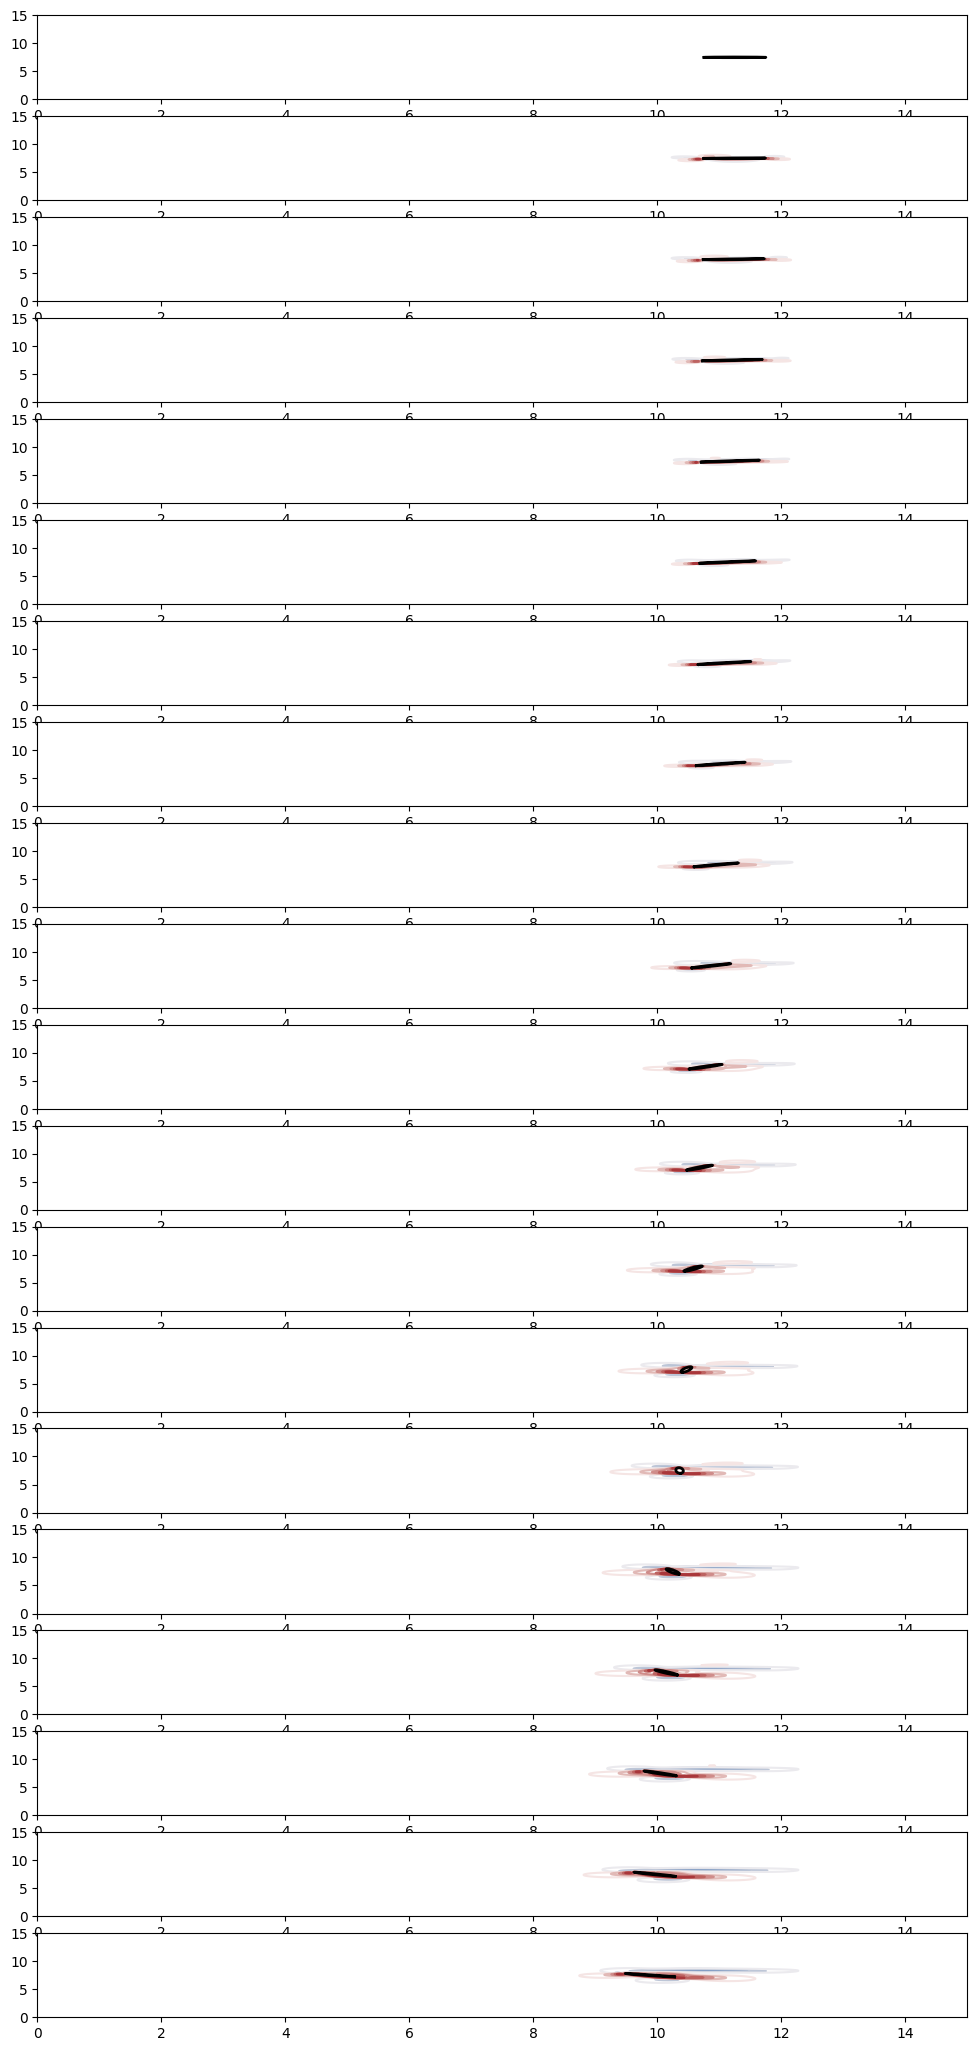

In [12]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from scipy.spatial.transform import Rotation
X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(trajectory,idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]))


    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid), vel_bc[0]),
                     grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid), vel_bc[1]))

    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=outer_steps//2)


counter=0
for idx in range(0,outer_steps,2):

    ax[counter].contour(X,Y,calc_vorticity(trajectory,idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))

    particles_list = trajectory.particles
    geometry_param=particles_list.geometry_param[idx][0]
    xp0,yp0 = ellipse(geometry_param,0)

    current_t = trajectory.velocity[0].bc.time_stamp[idx]
    particle_center = particles_list.particle_center[idx][0]

    theta_t = Rotation_EQ(rotation_param,current_t)
    xp = (xp0)*jnp.cos(theta_t)-(yp0)*jnp.sin(theta_t)+particle_center[0]
    yp = (xp0)*jnp.sin(theta_t)+(yp0 )*jnp.cos(theta_t)+particle_center[1]
    ax[counter].set_xlim([0,15])
    ax[counter].set_ylim([0,15])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1


In [34]:
type(final_result.velocity[0].array.data)

numpy.ndarray